In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seasons as ps

# Generate a time series

(define what you mean by time series) Here a time series is a chronological series of data point. for now there is no importance given to the timestamp at which the event happened, only the order is important.

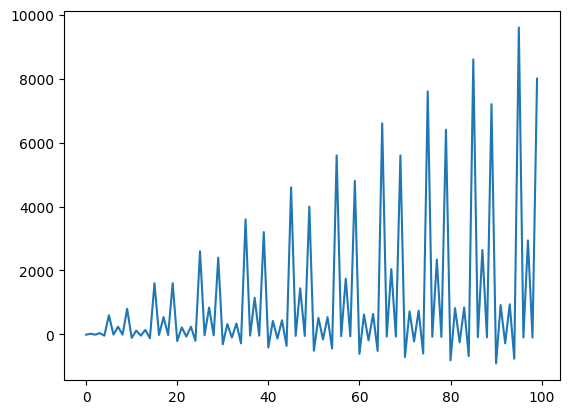

In [24]:
# Set seed
np.random.seed(0)

y = ps.utils.generate_series(
    length=100,
    trend='linear',
    trend_coefficient=1,
    seasonality=[[-1, 10], [10, 1, 3, 1, 8]], 
    seasonality_type='multiplicative',
    error_distribution='normal',
    error_scale=0
)

plt.plot(y)
plt.show()

In [25]:
y

array([-1.00e+01,  2.00e+01, -9.00e+00,  4.00e+01, -4.00e+01,  6.00e+02,
       -7.00e+00,  2.40e+02, -9.00e+00,  8.00e+02, -1.10e+02,  1.20e+02,
       -3.90e+01,  1.40e+02, -1.20e+02,  1.60e+03, -1.70e+01,  5.40e+02,
       -1.90e+01,  1.60e+03, -2.10e+02,  2.20e+02, -6.90e+01,  2.40e+02,
       -2.00e+02,  2.60e+03, -2.70e+01,  8.40e+02, -2.90e+01,  2.40e+03,
       -3.10e+02,  3.20e+02, -9.90e+01,  3.40e+02, -2.80e+02,  3.60e+03,
       -3.70e+01,  1.14e+03, -3.90e+01,  3.20e+03, -4.10e+02,  4.20e+02,
       -1.29e+02,  4.40e+02, -3.60e+02,  4.60e+03, -4.70e+01,  1.44e+03,
       -4.90e+01,  4.00e+03, -5.10e+02,  5.20e+02, -1.59e+02,  5.40e+02,
       -4.40e+02,  5.60e+03, -5.70e+01,  1.74e+03, -5.90e+01,  4.80e+03,
       -6.10e+02,  6.20e+02, -1.89e+02,  6.40e+02, -5.20e+02,  6.60e+03,
       -6.70e+01,  2.04e+03, -6.90e+01,  5.60e+03, -7.10e+02,  7.20e+02,
       -2.19e+02,  7.40e+02, -6.00e+02,  7.60e+03, -7.70e+01,  2.34e+03,
       -7.90e+01,  6.40e+03, -8.10e+02,  8.20e+02, 

# Seasonality detection

(introduce the different methods)

## Brute force

[[1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0.]
 

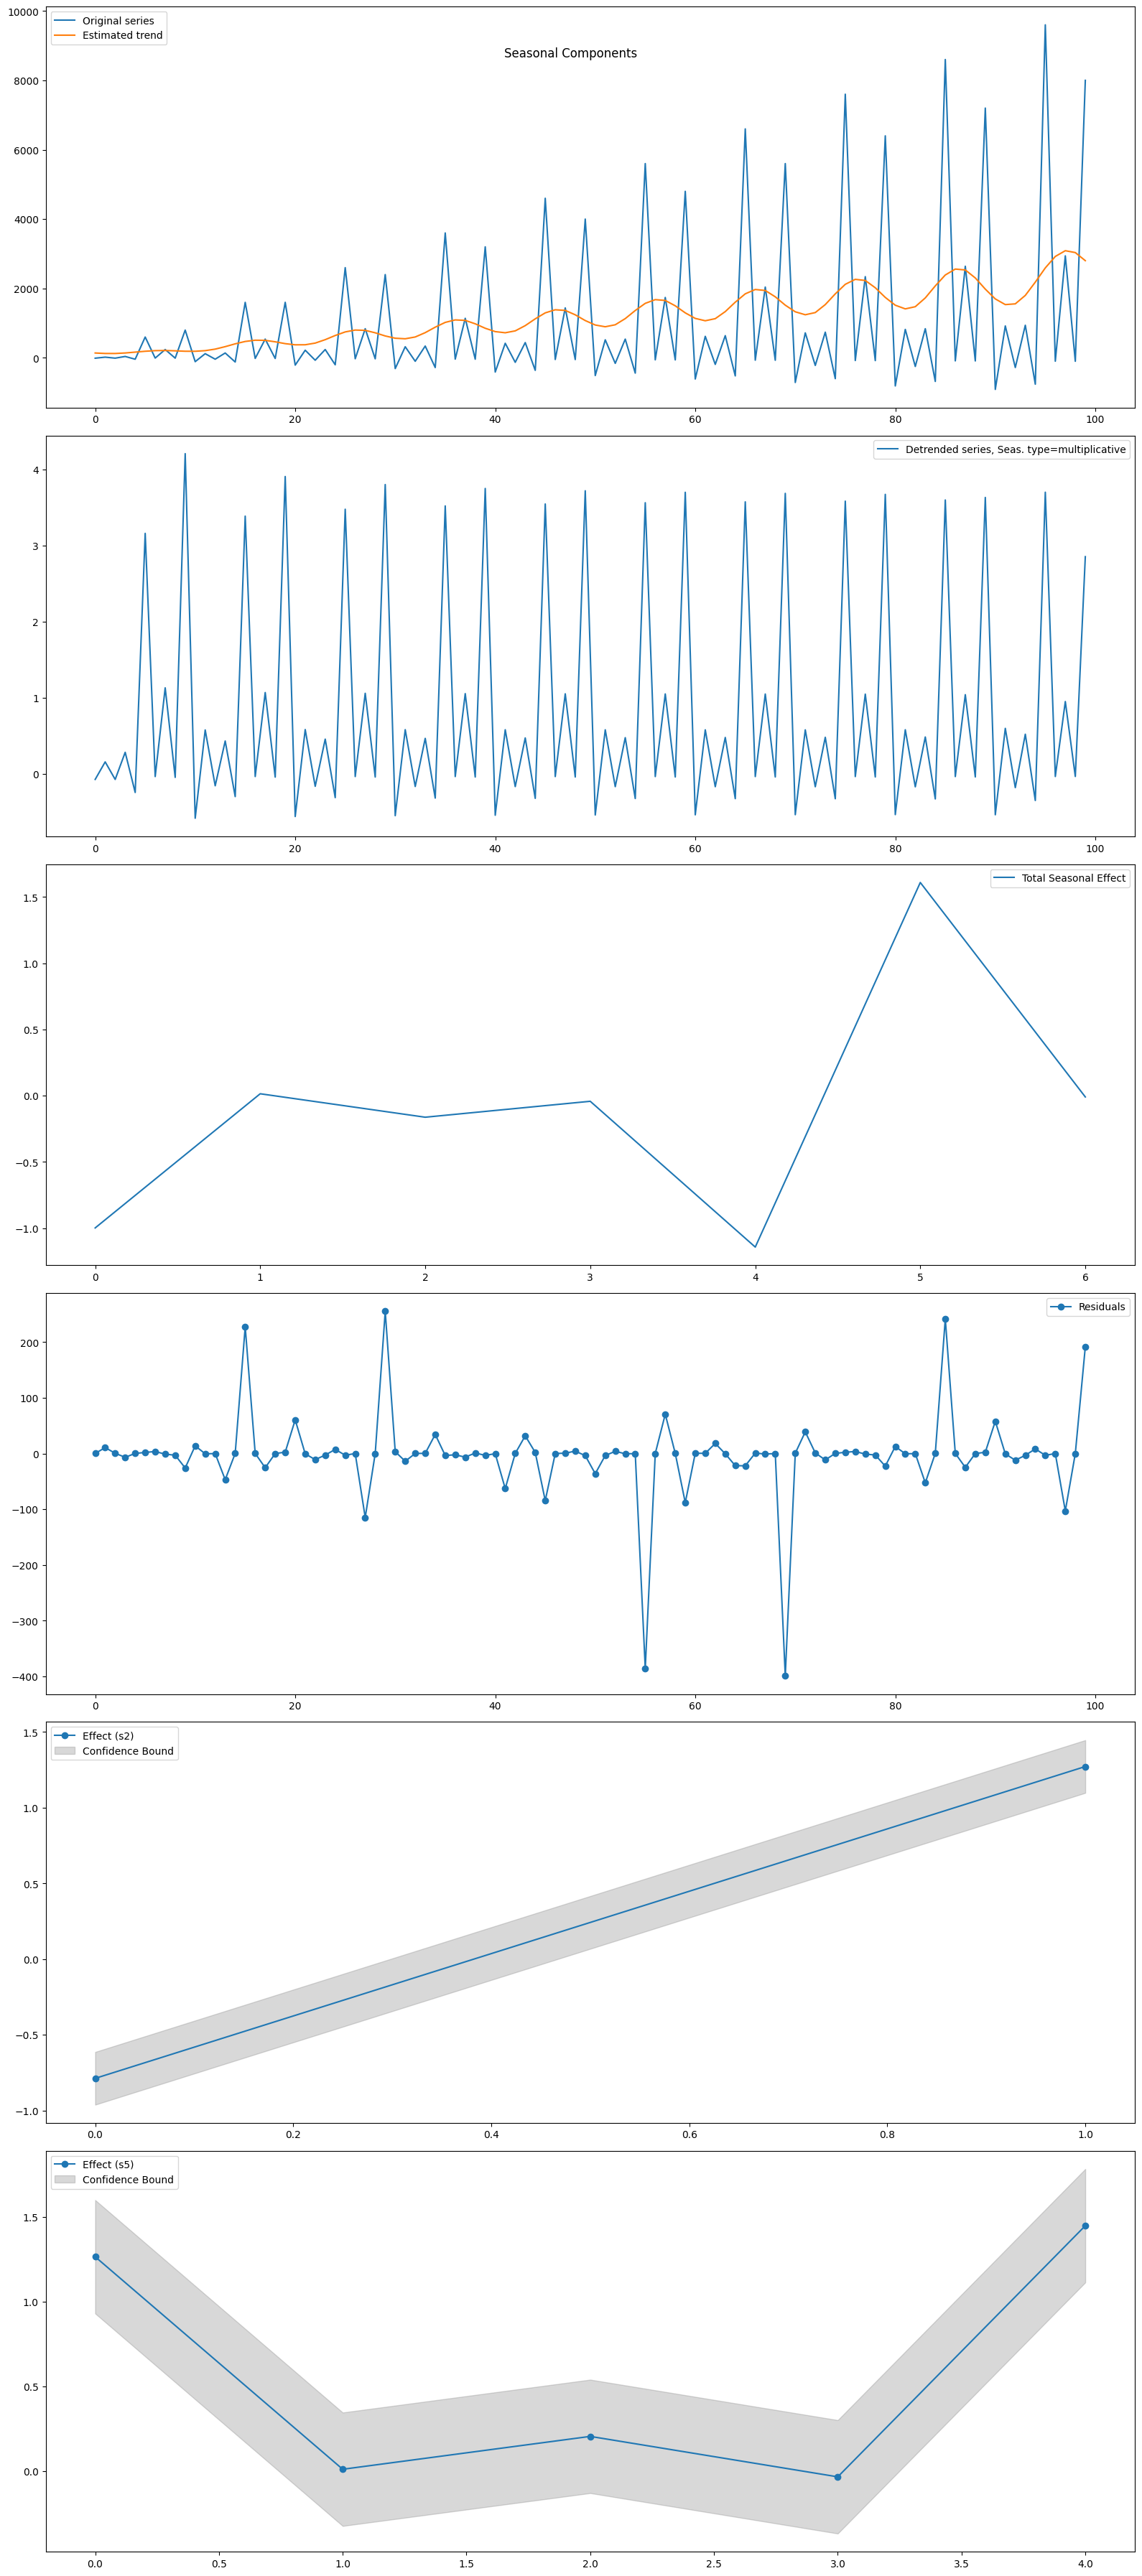

('multiplicative',
 {'s2': {'effect': [-0.7882386160508668, 1.2714591628442324],
   'confidence_interval': [[-0.9624161929559796, -0.6140610391457539],
    [1.0972815859391198, 1.445636739749345]]},
  's5': {'effect': [1.2657849001178907,
    0.011714181728175566,
    0.20571387701050597,
    -0.03298194588035391,
    1.4490922677840532],
   'confidence_interval': [[0.9310072820196054, 1.600562518216176],
    [-0.32306343637010976, 0.3464917998264609],
    [-0.12906374108777957, 0.5404914951087916],
    [-0.36775956397863924, 0.30179567221793135],
    [1.1143146496857674, 1.783869885882339]]}})

In [27]:
ps.detect.brute_force_seasonality(
    data=y,
    min_seasonality=2,
    seasonality_type='auto',
    alpha=0.05,
    display_plot=True,
    use_linear_reg=False,
    return_effects=True
)

In [9]:
from sklearn.linear_model import LinearRegression


In [6]:
def _generate_design_matrix(N, seasonal_periods):
    K = len(seasonal_periods)
    num_seasonal_effects = sum(seasonal_periods)
    A = np.zeros((N, num_seasonal_effects))
    
    effect_index = 0
    for k, xk in enumerate(seasonal_periods):
        for i in range(xk):
            for t in range(N):
                if t % xk == i:
                    A[t, effect_index + i] = 1
        effect_index += xk
    
    return A

In [7]:
X = _generate_design_matrix(len(y), [2, 5])

In [8]:
X

array([[1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0.],
 

In [10]:
model = LinearRegression()
model = model.fit(X, y)

In [12]:
model.intercept_

np.float64(10.1)

In [20]:
coeffs = np.linalg.lstsq(X, y,) 

In [21]:
coeffs

(array([ 2.71428571, 11.71428571,  8.28571429, -0.71428571,  1.28571429,
        -0.71428571,  6.28571429]),
 array([], dtype=float64),
 np.int32(6),
 array([8.36660027e+00, 7.07106781e+00, 4.47213595e+00, 4.47213595e+00,
        4.47213595e+00, 4.47213595e+00, 1.61798859e-15]))

In [15]:
help(np.linalg.lstsq)

Help on _ArrayFunctionDispatcher in module numpy.linalg:

lstsq(a, b, rcond=None)
    Return the least-squares solution to a linear matrix equation.
    
    Computes the vector `x` that approximately solves the equation
    ``a @ x = b``. The equation may be under-, well-, or over-determined
    (i.e., the number of linearly independent rows of `a` can be less than,
    equal to, or greater than its number of linearly independent columns).
    If `a` is square and of full rank, then `x` (but for round-off error)
    is the "exact" solution of the equation. Else, `x` minimizes the
    Euclidean 2-norm :math:`||b - ax||`. If there are multiple minimizing
    solutions, the one with the smallest 2-norm :math:`||x||` is returned.
    
    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of t